<a href="https://colab.research.google.com/github/HansakaDilshanJayawardana/MLAssignment/blob/model%2FGNN-Model/Transfer_Learning_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np 
from PIL import Image
import pandas as pd
import glob
import os
import shutil
import sklearn as sklearn
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns
# Stop the training when there is no improvement in the loss for three consecutive epochs
from keras.callbacks import EarlyStopping
# Model performance metrics
from sklearn.metrics import classification_report

In [2]:
#Remove any file and Delete .kaggle directory
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
#Install Kaggle
!pip install -q kaggle

In [4]:
#To upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hansakajayawardana","key":"44881d9d76ac3feedc68f490d49dc0a3"}'}

In [5]:
#To save this file into a directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

#To change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#Download the Fashion MNIST dataset from Kaggle
!kaggle datasets download -d zalando-research/fashionmnist

 90% 62.0M/68.8M [00:00<00:00, 165MB/s]
100% 68.8M/68.8M [00:00<00:00, 159MB/s]


In [7]:
#Extract the files in the zip file
!unzip -n 'fashionmnist.zip'

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [8]:
#Load Data 
train = pd.read_csv('fashion-mnist_train.csv', sep=',')
test = pd.read_csv('fashion-mnist_test.csv', sep=',')

In [9]:
# Train Head
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Test Head
test.head(5) 

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Print the number of rows and columns in the train and test datasets
print("Fashion MNIST train -  rows:",train.shape[0]," columns:", train.shape[1])
print("Fashion MNIST test -  rows:",test.shape[0]," columns:", test.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


In [12]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

# Get Classes Distribution Method Implementation
def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

# Calculate the distribution of the classes in the training dataset
get_classes_distribution(train)

Pullover            :   6000 or 10.0%
Ankle Boot          :   6000 or 10.0%
Shirt               :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Trouser             :   6000 or 10.0%


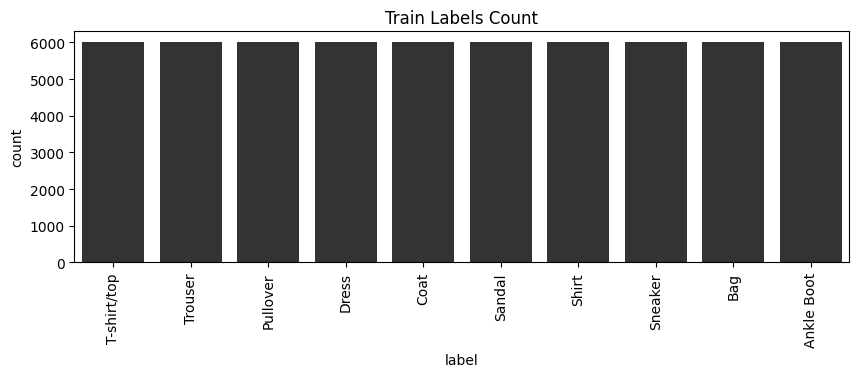

In [13]:
# Plot Label Per Class Method Implementation for Training Dataset
def plot_label_per_class(train):
    # Convert train to pandas dataframe
    train_df = pd.DataFrame(train)

    # Create plot
    plt.figure(figsize=(10, 3))
    ax = sns.countplot(x='label', data=train_df, palette=['#333333' for i in range(10)])
    plt.xticks(list(labels.keys()), list(labels.values()), rotation='vertical')
    ax.set_title('Train Labels Count')

    plt.show()

# Visualize the class distribution in the training dataset
plot_label_per_class(train)

In [14]:
# Calculate the distribution of the classes in the testing dataset
get_classes_distribution(test)

T-shirt/top         :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Dress               :   1000 or 10.0%
Bag                 :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Sneaker             :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%


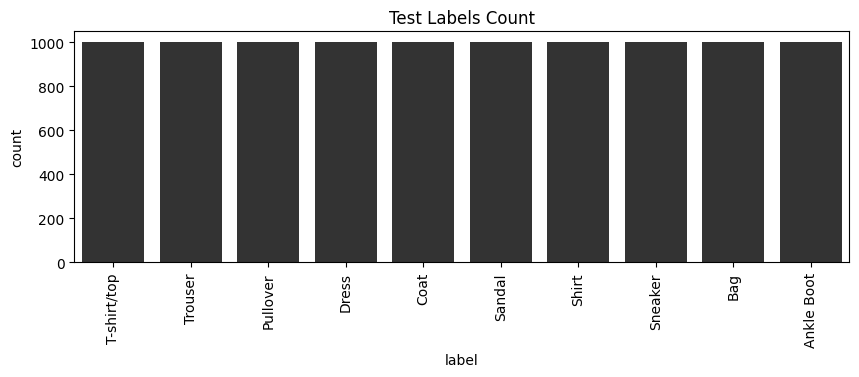

In [15]:
# Plot Label Per Class Method Implementation for Testing Dataset
def plot_label_per_class(test):
    # Convert test to pandas dataframe
    test_df = pd.DataFrame(test)

    # Create plot
    plt.figure(figsize=(10, 3))
    ax = sns.countplot(x='label', data=test_df, palette=['#333333' for i in range(10)])
    plt.xticks(list(labels.keys()), list(labels.values()), rotation='vertical')
    ax.set_title('Test Labels Count')

    plt.show()

# Visualize the class distribution in the testing dataset
plot_label_per_class(test)

In [16]:
# Rescaling image data
train_images = np.array(train.iloc[:, 1:])
train_labels = np.array(train.iloc[:, 0])
test_images = np.array(test.iloc[:, 1:])
test_labels = np.array(test.iloc[:, 0])

In [18]:
# Reshaping images
new_shape = (64, 64)
x_train_resized = np.zeros((train_images.shape[0], new_shape[0], new_shape[1]))
x_test_resized = np.zeros((test_images.shape[0], new_shape[0], new_shape[1]))

In [19]:
# View Training Images Data
x_train_resized

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [20]:
# View Training Labels Data
train_labels

array([2, 9, 6, ..., 8, 8, 7])

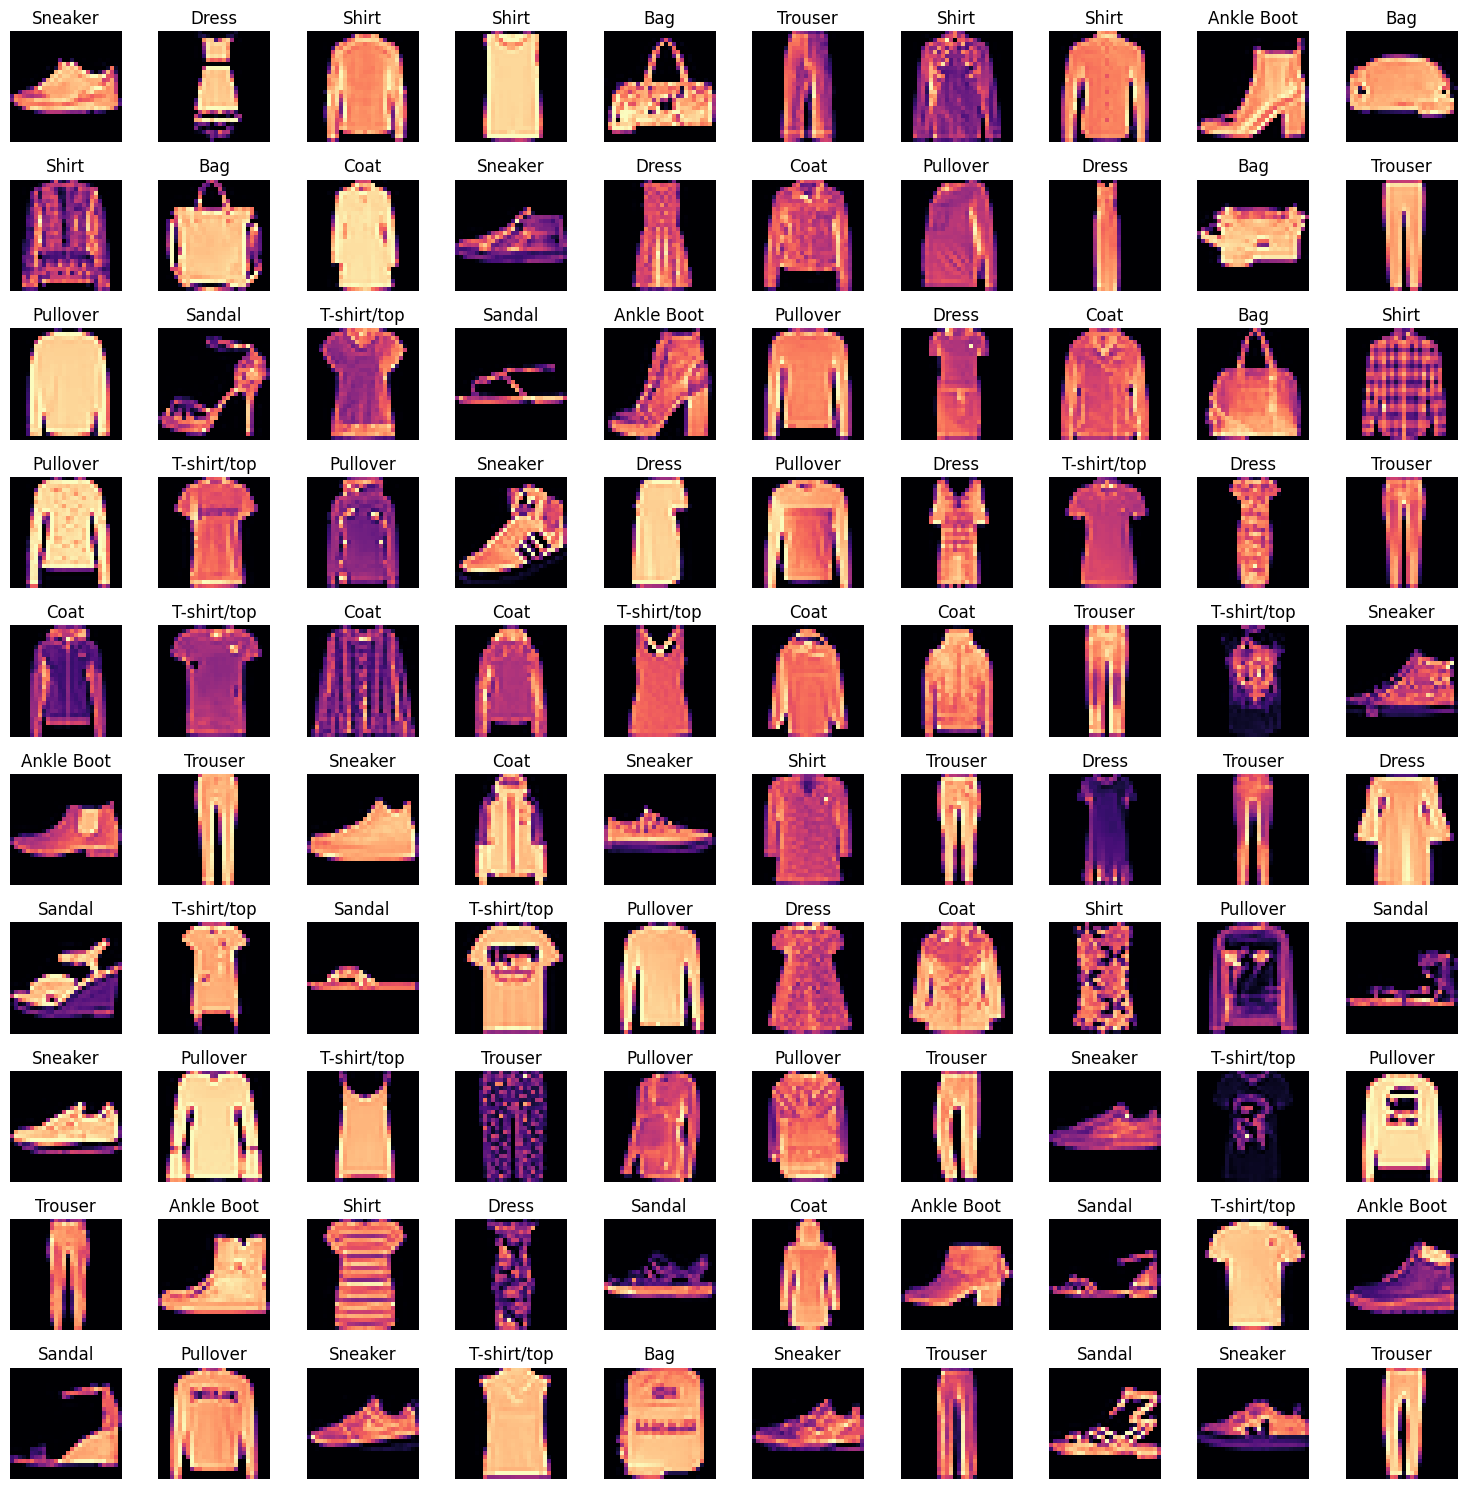

In [24]:
# Data Visualization
# Class Names from Dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# First few train images with labels
columns = 10
rows = 10
fig = plt.figure(figsize=(15, 15))

for i in range(1, columns * rows+1):
    data_idx = np.random.randint(len(train_images))
    img = train_images[data_idx].reshape([28,28])
    label = labels[train_labels[data_idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='magma')
    plt.axis('off')
plt.tight_layout()
plt.show()

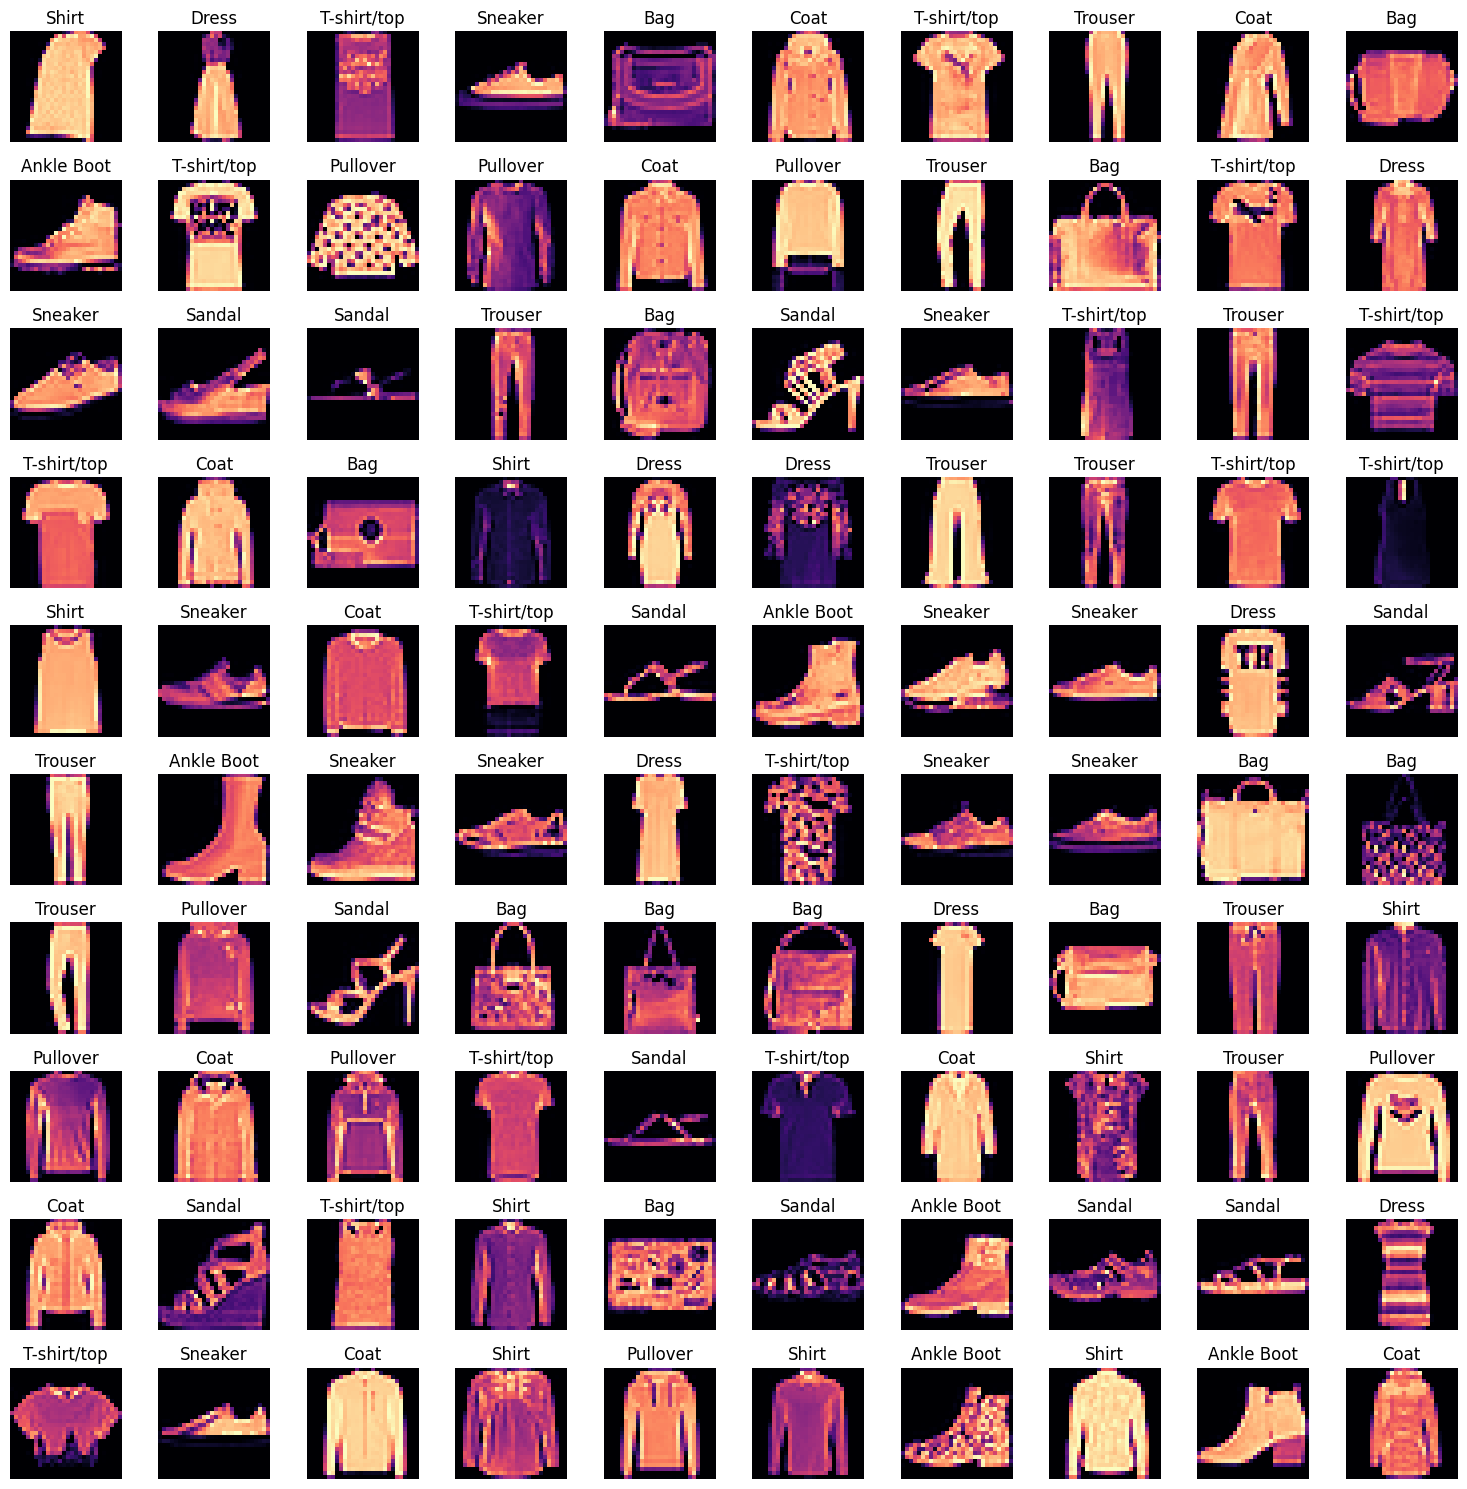

In [25]:
# First few test images with labels
columns = 10
rows = 10
fig = plt.figure(figsize=(15, 15))

for i in range(1, columns * rows+1):
    data_idx = np.random.randint(len(test_images))
    img = test_images[data_idx].reshape([28, 28])
    label = labels[test_labels[data_idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='magma')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
#One hot encoding targets
y_train_enc = to_categorical(train_labels, num_classes=10)
y_test_enc = to_categorical(test_labels, num_classes=10)

In [27]:
#Train validation split
X_train, X_val, y_train_enc, y_val_enc = train_test_split(x_train_resized, y_train_enc, test_size=0.3)

In [28]:
#Build the model
def get_model():

    base_model = VGG19(input_shape=(64,64,1), weights=None , include_top=False,classes=10)
   
    for layer in base_model.layers:
        layer.trainable = False
        
   

    x = Flatten()(base_model.output)
    # Adding fully connected layer
    x = Dense(64, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [29]:
model = get_model()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [31]:
# Halt the training to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [32]:
# Model Fitting
history = model.fit(X_train, y_train_enc, epochs=30, batch_size=128, verbose=2, callbacks=[early_stopping], validation_data=(X_val, y_val_enc))

Epoch 1/30
329/329 - 35s - loss: 2.3027 - accuracy: 0.0994 - val_loss: 2.3027 - val_accuracy: 0.0999 - 35s/epoch - 107ms/step
Epoch 2/30
329/329 - 22s - loss: 2.3027 - accuracy: 0.0994 - val_loss: 2.3027 - val_accuracy: 0.0967 - 22s/epoch - 67ms/step
Epoch 3/30
329/329 - 23s - loss: 2.3027 - accuracy: 0.0972 - val_loss: 2.3027 - val_accuracy: 0.0967 - 23s/epoch - 69ms/step
Epoch 4/30
329/329 - 26s - loss: 2.3027 - accuracy: 0.0972 - val_loss: 2.3028 - val_accuracy: 0.0967 - 26s/epoch - 80ms/step
Epoch 5/30
329/329 - 23s - loss: 2.3027 - accuracy: 0.1014 - val_loss: 2.3027 - val_accuracy: 0.0967 - 23s/epoch - 68ms/step
Epoch 6/30
329/329 - 26s - loss: 2.3027 - accuracy: 0.1014 - val_loss: 2.3027 - val_accuracy: 0.0967 - 26s/epoch - 79ms/step


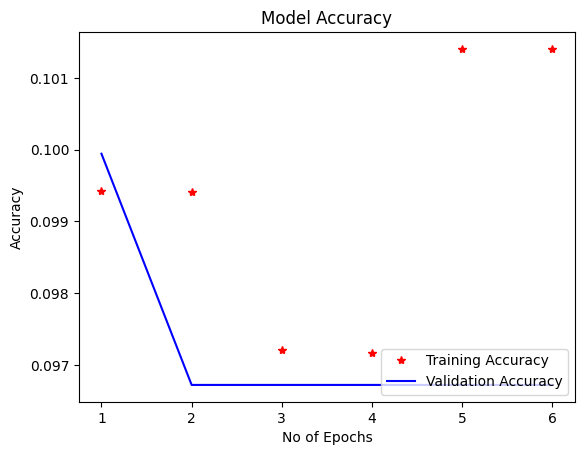

In [38]:
# Data Visualization
# Accuracy plot graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r*', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('./vgg19_accuracy_plot.png')
plt.show()

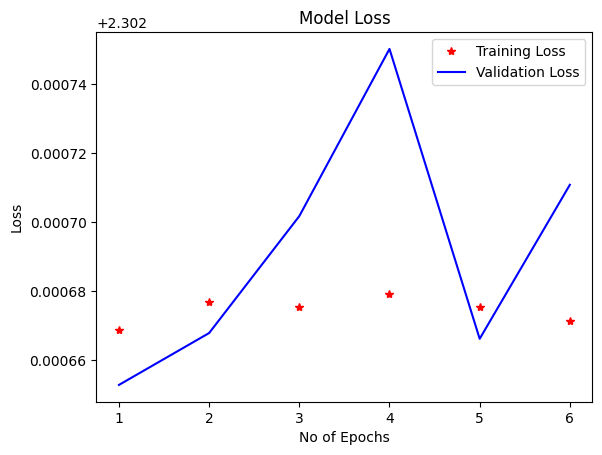

In [39]:
# Data Visualization
# Loss plot graph
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r*', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('./vgg19_loss_plot.png')
plt.show()

In [56]:
# Predicted values
y_pred = model.predict(X_val)

# Decode predicted labels
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred , num_classes=10)
print(classification_report(y_val_enc, y_pred, target_names=class_names))

563/563 [==============================] - 9s 16ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1792
     Trouser       0.00      0.00      0.00      1801
    Pullover       0.00      0.00      0.00      1799
       Dress       0.00      0.00      0.00      1805
        Coat       0.00      0.00      0.00      1793
      Sandal       0.00      0.00      0.00      1834
       Shirt       0.00      0.00      0.00      1799
     Sneaker       0.10      1.00      0.18      1741
         Bag       0.00      0.00      0.00      1838
  Ankle boot       0.00      0.00      0.00      1798

   micro avg       0.10      0.10      0.10     18000
   macro avg       0.01      0.10      0.02     18000
weighted avg       0.01      0.10      0.02     18000
 samples avg       0.10      0.10      0.10     18000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
